# Transfer Learning with TensorFlow - Fine Tuning

In [ ]:
# Check if we're using gpu

!nvidia-smi

Fri Oct 21 04:06:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    32W /  70W |   4920MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

We could rewrite them, but this is tedious

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-10-26 03:27:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-26 03:27:21 (47.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
#Import helper functions we're going to use in this notebook

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir



## Let's get some data

This time, we're going to see how we can use the pretrained model within tf.keras.applications and apply them to our own problem (recogniziing images of food)



In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-10-26 03:27:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   170MB/s    in 0.9s    

2022-10-26 03:27:31 (170 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
# Check out how many images and sub directories our in our data set

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [7]:
# Create training and test directory paths

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [8]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE=32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[171.6486    169.41327   158.11926  ]
   [172.49107   170.42793   158.61734  ]
   [179.18558   177.18558   165.18558  ]
   ...
   [204.77167   148.65048    74.711075 ]
   [221.58546   167.71173    93.64859  ]
   [224.39731   170.86797    96.63264  ]]

  [[177.43813   177.68687   170.61607  ]
   [178.79655   179.63393   171.5051   ]
   [183.3514    184.8935    174.4375   ]
   ...
   [229.05742   176.986     100.985985 ]
   [221.82207   172.62883    96.69324  ]
   [221.20026   172.06442    96.109695 ]]

  [[183.30357   185.868     181.89285  ]
   [184.49107   187.84248   181.25319  ]
   [187.3935    190.68877   184.24236  ]
   ...
   [221.2398    171.706      94.883934 ]
   [228.49683   179.07143   102.18751  ]
   [225.62692   178.19836   100.41264  ]]

  ...

  [[ 46.435642   27.435644   10.864172 ]
   [ 46.35721    27.357208   10.785736 ]
   [ 48.5632     29.5632     12.991727 ]
   ...
   [ 94.49877    60.49877    25.498774 ]
   [ 92.214264   58.214264   23.214264 ]
   [ 

## Model 0: Building a transfer learning model using the Keras Sequential API

The sequential API is straightforward, it runs out layers in sequential order, but the functional api gives us more flexibility with our models


In [ ]:
# 1. Create the base model tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pretrained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224, 3), name = "Input Layer")

# 4. If using ResNet50V2 you will need to normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model 
x = base_model(inputs)

print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most import information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after global average pooling 2d: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation ="softmax", name = "output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model

model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_0_history = model_0.fit(train_data_10_percent, 
                              epochs = 5,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data = train_data_10_percent,
                              validation_steps = int(len(test_data)*.25),
                              callbacks = [create_tensorboard_callback("transfer_learning",
                                                                       "10_percent_feature_extraction",)])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after global average pooling 2d: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20221021-040644
Epoch 1/5
24/24 [==============================] - 12s 256ms/step - loss: 1.8209 - accuracy: 0.4680 - val_loss: 1.2488 - val_accuracy: 0.7352
Epoch 2/5
24/24 [==============================] - 4s 158ms/step - loss: 1.0742 - accuracy: 0.7733 - val_loss: 0.8178 - val_accuracy: 0.8520
Epoch 3/5
24/24 [==============================] - 4s 157ms/step - loss: 0.7877 - accuracy: 0.8333 - val_loss: 0.6418 - val_accuracy: 0.8750
Epoch 4/5
24/24 [==============================] - 4s 157ms/step - loss: 0.6329 - accuracy: 0.8680 - val_loss: 0.5349 - val_accuracy: 0.8832
Epoch 5/5
24/24 [==============================] - 4s 159ms/step - loss: 0.5432 - accuracy: 0.8840 - val_loss: 0.4583 - val_accuracy: 0.9079


In [ ]:
#Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.5477 - accuracy: 0.8668


[0.5476923584938049, 0.8668000102043152]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_14
1 rescaling_13
2 normalization_13
3 tf.math.truediv_13
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expan

In [ ]:
# Summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_13 (Rescaling)       (None, None, None,   0           ['input_14[0][0]']               
                                3)                                                                
                                                                                                  
 normalization_13 (Normalizatio  (None, None, None,   7          ['rescaling_13[0][0]']           
 n)                             3)                                                   

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


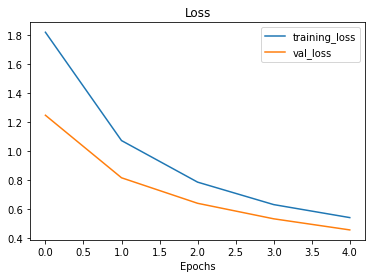

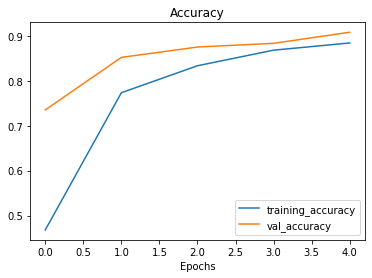

In [ ]:
# Check out our model's training curves

plot_loss_curves(model_0_history)

## Getting a feature vector from a trained model

Let's demonstrate the global average pooling 2d layer



In [ ]:
# Define the input shape
input_shape = (1,4,4,3)

# create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"random input tensor \n {input_tensor} \n")

# Pass the random tensor through a global average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor \n {global_average_pooled_tensor} \n")

# Check shape
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of input global average pooled 2d tensor: {global_average_pooled_tensor.shape}")

random input tensor 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D global average pooled random tensor 
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of input global average pooled 2d tensor: (1, 3)


In [ ]:
# Let's replicate the Global Average Pooled 2D Layer
tf.reduce_mean(input_tensor, axis =[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we setup a bunch of experiments to find out

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2022-10-21 04:07:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M   281MB/s    in 0.5s    

2022-10-21 04:07:30 (281 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [ ]:
train_dir = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [ ]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [ ]:
# Setup data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model



In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotation, zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1/255.)
], name = "data_augmentation")

## Visualize data ugmentation layer (and see what happens to our data)

In [13]:
# View a random image and compare it to its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in random image
img = mpimg.imread(random_image_path)

plt.imshow(img)
plt.title(f"Original Random image from {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_image = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False)

NameError: ignored

## Model 1: FE transfer learning on1% w/ data augmentation

In [1]:
# Setup input shape and base model

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")
#Data augmentation sequential model as a layer
x = data_augmentation(inputs)

#give base model inputs after augmented
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# put a dense layer on as the ouput
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])
history_1 = model_1.fit(train_data_1_percent,
                        epochs =5,
                        steps_per_epoch = len(train_data_1_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback("transfer_learning",
                                                                "1_percent_data_aug")])


NameError: ignored

In [ ]:
# model summary
model_1.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-train

In [ ]:
# Evaluate on full test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 1.7938 - accuracy: 0.4676


[1.7938419580459595, 0.4675999879837036]

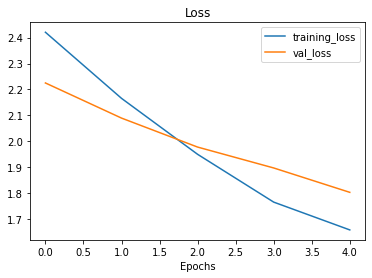

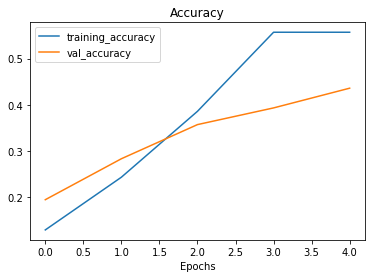

In [ ]:
# How do the model with 1% of the data and data aug loss curves look

plot_loss_curves(history_1)

In [16]:
# Setup input shape and base model
input_shape = (224,224,3)
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name="Global_average_pooled_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = keras.Model(inputs, outputs)
  
model_2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics="accuracy")




16705208/16705208 [==============================] - 0s 0us/step


## Create a modelcheckpoint callback

In [10]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckps"

# Create a model checkpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

In [ ]:
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                              experiment_name="10_percent_data_aug"),
                                  checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20221026-033001
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9395 - accuracy: 0.3827
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckps
24/24 [==============================] - 28s 610ms/step - loss: 1.9395 - accuracy: 0.3827 - val_loss: 1.3855 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2642 - accuracy: 0.7147
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckps
24/24 [==============================] - 12s 469ms/step - loss: 1.2642 - accuracy: 0.7147 - val_loss: 0.9585 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9751 - accuracy: 0.7773
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckps
24/24 [==============================] - 10s 421ms/step - loss: 0.9751 - accuracy: 0.7773 - val_loss: 0.7603 - val_accuracy: 0.8421
E

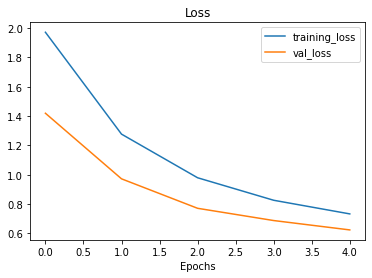

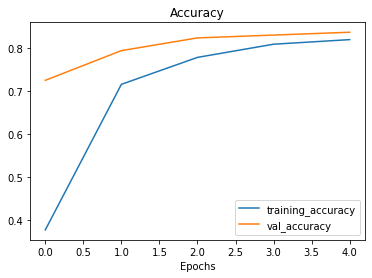

In [ ]:
plot_loss_curves(history_2)

### Loading in checkpointed weights


### Loading in checkpointed weights

-returns a model to a specific checkpoint

In [9]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

NameError: ignored